In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os

In [2]:
tf.random.set_seed(42)
np.random.seed(42)
BASE_PATH = 'D:\\fauzan\\1KULIAH\\SEMESTER 3\\DATA MINING\\food_recognition'


def validate_dataset():
    print("Validasi dataset...")
    
    # Cek path
    if not os.path.exists(BASE_PATH):
        raise Exception(f"Path tidak ditemukan: {BASE_PATH}")
    
    # Cek subfolder dan annotations
    for folder in ['train', 'test', 'valid']:
        folder_path = os.path.join(BASE_PATH, folder)
        annotation_path = os.path.join(folder_path, '_annotations.csv')
        
        if not os.path.exists(folder_path):
            raise Exception(f"Folder tidak ditemukan: {folder_path}")
        if not os.path.exists(annotation_path):
            raise Exception(f"File annotations tidak ditemukan: {annotation_path}")
            
        # Hitung jumlah item
        items = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
        print(f"Jumlah item di folder {folder}: {items}")
        
        # Validasi jumlah yang diharapkan
        expected = {'test': 550, 'train': 5131, 'valid': 551}
        if items-1 != expected[folder]:  # -1 karena ada file _annotations.csv
            print(f"Warning: Jumlah item di folder {folder} ({items-1}) berbeda dengan yang diharapkan ({expected[folder]})")
    
    print("Validasi dataset selesai!")

In [3]:
def load_data():
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train/_annotations.csv'))
    valid_df = pd.read_csv(os.path.join(BASE_PATH, 'valid/_annotations.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test/_annotations.csv'))
    
    # Tambahkan kolom path gambar
    train_df['image_path'] = 'train/' + train_df['filename']
    valid_df['image_path'] = 'valid/' + valid_df['filename']
    test_df['image_path'] = 'test/' + test_df['filename']
    
    return train_df, valid_df, test_df

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32  # Sesuai untuk dataset size 5131
EPOCHS = 50

# Jalankan validasi dataset
validate_dataset()

# Load data
train_df, valid_df, test_df = load_data()

Validasi dataset...
Jumlah item di folder train: 5131
Jumlah item di folder test: 550
Jumlah item di folder valid: 551
Validasi dataset selesai!


In [5]:
num_classes = len(train_df['class'].unique())
print(f"Jumlah kelas: {num_classes}")
print(f"Daftar kelas: {train_df['class'].unique()}")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Jumlah kelas: 21
Daftar kelas: ['puding' 'kentang goreng' 'bakso' 'capcay' 'nasi' 'sate' 'telur dadar'
 'sop' 'telur ceplok' 'roti tawar' 'rendang' 'ayam goreng'
 'tumis kangkung' 'ayam bakar' 'tahu goreng' 'donat' 'ikan bakar'
 'tempe goreng' 'telur rebus' 'ikan goreng' 'kentang rebus']


In [6]:
# Buat generator untuk data training, validasi, dan testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=BASE_PATH,
    x_col='image_path',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 7314 validated image filenames belonging to 21 classes.


In [7]:
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=BASE_PATH,
    x_col='image_path',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=BASE_PATH,
    x_col='image_path',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 865 validated image filenames belonging to 21 classes.
Found 804 validated image filenames belonging to 21 classes.


In [8]:
# # Buat model CNN
# model = Sequential([
#     # Blok Konvolusi 1
#     Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
#     MaxPooling2D(2, 2),
    
#     # Blok Konvolusi 2
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
    
#     # Blok Konvolusi 3
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
    
#     # Blok Konvolusi 4
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
    
#     # Flatten layer
#     Flatten(),
    
#     # Dense layers
#     Dense(512, activation='relu'),
#     Dropout(0.5),
#     Dense(num_classes, activation='softmax')
# ])

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Load MobileNetV2 model with pretrained weights from ImageNet, exclude top layers
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

# base_model = load_model('/content/drive/MyDrive/DataSlayer/954_CNN_mobileNet_multiclass.h5')

# Freeze all layers in the base model (optional: untuk menjaga agar tidak terlalu banyak parameter yang di-update)
base_model.trainable = False

# Tambahkan lapisan tambahan untuk penyesuaian output
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Lapisan pooling global
x = Dense(64, activation='relu')(x)  # Additional dense layer with 64 neurons
x = Dropout(0.1)(x)  # Dropout for regularization
x = Dense(32, activation='relu')(x)  # Additional dense layer with 32 neurons
x = Dropout(0.1)(x)  # Dropout for regularization

# Output layer (sesuaikan jumlah kelas, misal 10 untuk klasifikasi 10 kelas)
output_layer = Dense(num_classes, activation='softmax')(x)

for layer in base_model.layers[-4:]:  # Misalnya, buka 4 lapisan terakhir
    layer.trainable = True

model = Model(inputs=base_model.input, outputs=output_layer)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,342,741 (8.94 MB)

 Trainable params: 497,557 (1.90 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

In [10]:
# Compile model
model.compile(
    optimizer='adam',  # Pilih optimizer yang sesuai
    loss='categorical_crossentropy',  # Sesuaikan dengan jenis masalah, misal 'categorical_crossentropy' untuk klasifikasi
    metrics=['accuracy']  # Tambahkan metrik yang diinginkan, seperti 'accuracy'
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',   # Metrik yang ingin dipantau
    factor=0.5,               # Faktor pengurangan lr, lr baru = lr * factor
    patience=3,               # Jumlah epoch tanpa perbaikan sebelum lr dikurangi
    min_lr=1e-6,              # Batas minimum untuk lr
    verbose=1
)

# Training model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, checkpoint]
)


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 140s 595ms/step - accuracy: 0.5499 - loss: 1.5332 - val_accuracy: 0.7965 - val_loss: 0.8891
Epoch 2/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 102s 445ms/step - accuracy: 0.8571 - loss: 0.4782 - val_accuracy: 0.8208 - val_loss: 0.7287
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 103s 448ms/step - accuracy: 0.8771 - loss: 0.3999 - val_accuracy: 0.8532 - val_loss: 0.5835
Epoch 4/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 132s 578ms/step - accuracy: 0.9070 - loss: 0.3156 - val_accuracy: 0.8532 - val_loss: 0.6578
Epoch 5/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 105s 457ms/step - accuracy: 0.9007 - loss: 0.3083 - val_accuracy: 0.8717 - val_loss: 0.5795
Epoch 6/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 105s 458ms/step - accuracy: 0.9239 - loss: 0.2368 - val_accuracy: 0.8601 - val_loss: 0.6860
Epoch 7/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 103s 448ms/step - accuracy: 0.9255 - loss: 0.2198 - val_accuracy: 0.8821 - val_loss: 0.5587
Epoch 8/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 100s 437ms/step - accuracy: 0.9279 -

In [11]:

# Evaluasi model pada test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step - accuracy: 0.8530 - loss: 0.5297
Test accuracy: 0.8644


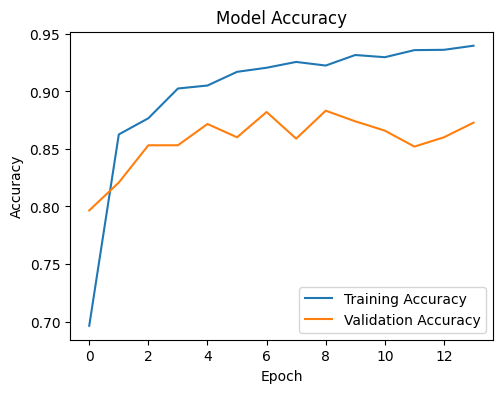

In [12]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

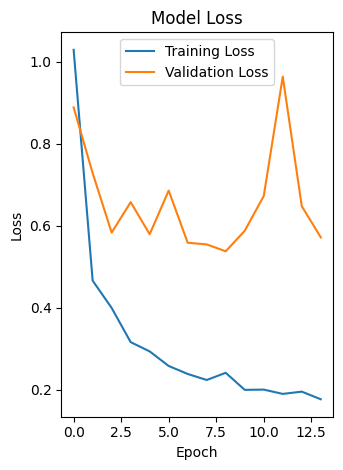

In [13]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Fungsi untuk prediksi gambar baru
def predict_image(image_path):
    # Load dan preprocess gambar
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(IMG_SIZE, IMG_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = img_array / 255.0
    
    # Prediksi
    predictions = model.predict(img_array)
    class_names = list(train_generator.class_indices.keys())
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])
    
    return predicted_class, confidence

predicted_class, confidence = predict_image('D:\\fauzan\\testing\\bakso.jpg')
print(f'Predicted class: {predicted_class}')
print(f'Confidence: {confidence:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Predicted class: bakso
Confidence: 1.00


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step


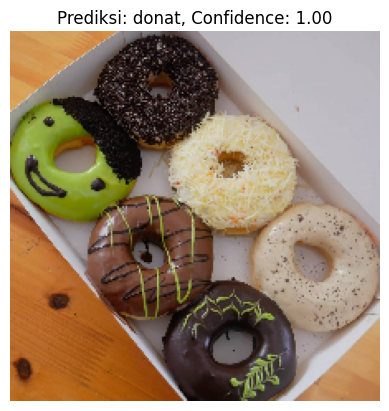

In [16]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Memuat model dengan format .keras
model = tf.keras.models.load_model("D:\\fauzan\\1KULIAH\\SEMESTER 3\\DATA MINING\\food_recognition\\best_model.keras")

# Mendefinisikan nama kelas
class_names = ['ayam bakar', 'ayam goreng', 'bakso', 'capcay', 'donat','ikan bakar', 'ikan goreng',
 'kentang goreng', 'kentang rebus', 'nasi',  'puding', 'rendang',
 'roti tawar', 'sate', 'sop', 'tahu goreng', 'telur ceplok',
 'telur dadar', 'telur rebus', 'tempe goreng', 'tumis kangkung']

# Path ke gambar yang ingin diuji
path_to_new_image = "D:\\fauzan\\testing\\donat1.jpg"

# Muat gambar
img = image.load_img(path_to_new_image, target_size=(224, 224)) 
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch

# Normalisasi jika diperlukan (misal, jika model dilatih dengan data yang dinormalisasi)
img_array = img_array / 255.0

# Lakukan prediksi
prediksi = model.predict(img_array)

# Mendapatkan kelas dengan confidence tertinggi
predicted_class = np.argmax(prediksi)
confidence = prediksi[0][predicted_class]

# Tampilkan hasil
plt.imshow(img)
plt.title(f"Prediksi: {class_names[predicted_class]}, Confidence: {confidence:.2f}")
plt.axis('off')
plt.show()
